In [1]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


# Load real observations

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# Preprocessing

In [4]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))

In [5]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


/tmp/ipykernel_469/4168053547.py:13: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_469/4168053547.py:15: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


In [6]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])

In [7]:
time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = np.zeros((len(dic_forced_response_ssp585.keys()), time_period))
x_predictor = np.zeros((len(dic_forced_response_ssp585.keys()), time_period, grid_lat_size, grid_lat_size))

In [8]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = 0
    x_predictor[m] = 0
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        if idx_i ==0:
            y_forced_response[m] = dic_forced_response_ssp585[m][i][131:164]
            x_predictor[m] = dic_processed_ssp585[m][i][131:164,:,:]
        else:
            y_forced_response[m] = np.concatenate([y_forced_response[m],dic_forced_response_ssp585[m][i][131:164]])
            x_predictor[m] = np.concatenate([x_predictor[m], dic_processed_ssp585[m][i][131:164,:,:]],axis=0)        

In [9]:
# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

In [10]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.from_numpy(np.nan_to_num(x_predictor[m]).reshape(x_predictor[m].shape[0],x_predictor[m].shape[1]*x_predictor[m].shape[2])).to(torch.float64)
    y_train[m] = torch.from_numpy(np.nan_to_num(y_forced_response[m])).to(torch.float64)

    nans_idx = np.where(np.isnan(x_predictor[m][0,:,:].ravel()))[0]

# Define diffusion model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class Diffusion(nn.Module):
    def __init__(self, dim, num_steps, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super(Diffusion, self).__init__()
        self.dim = dim
        self.num_steps = num_steps
        self.device = device
        self.sqrt_alpha_t = nn.Parameter(torch.randn(dim) * 0.01)
        self.beta_t = nn.Parameter(torch.randn(dim) * 0.01)

    def diffusion_process(self, x, t):
        """
        Generate noise conditioned on time t.
        """
        sqrt_alpha_t = self.sqrt_alpha_t * np.sqrt(t)
        beta_t = self.beta_t * t
        noise = torch.randn_like(x).to(self.device)
        x = x + sqrt_alpha_t * noise + beta_t
        return x

    def reverse_diffusion_process(self, x, t):
        """
        Reverse the diffusion process.
        """
        sqrt_alpha_t = self.sqrt_alpha_t * np.sqrt(t)
        beta_t = self.beta_t * t
        x = x - sqrt_alpha_t * torch.randn_like(x).to(self.device) - beta_t
        return x

    def forward(self, x, t):
        """
        Perform one step of the diffusion process.
        """
        x = self.diffusion_process(x, t)
        return x

    def reverse(self, x, t):
        """
        Reverse the diffusion process.
        """
        x = self.reverse_diffusion_process(x, t)
        return x

class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, dim)
        )

    def forward(self, z):
        return self.net(z)

class DDIM(nn.Module):
    def __init__(self, dim, num_steps):
        super(DDIM, self).__init__()
        self.dim = dim
        self.num_steps = num_steps
        self.generator = Generator(dim)
        self.diffusion = Diffusion(dim, num_steps)

    def forward(self, z, t):
        """
        Perform the Denoising Diffusion Model forward pass.
        """
        x = self.generator(z)
        for i in range(self.num_steps):
            x = self.diffusion(x, t)
        return x

# Example usage
dim = grid_lat_size*grid_lon_size
num_steps = 100
generator = Generator(dim)
diffusion = Diffusion(dim, num_steps)
model = DDIM(dim, num_steps)

In [17]:
from torch.utils.data import DataLoader,Dataset, TensorDataset

# Generate synthetic data
num_samples = 400
# data = generate_synthetic_data(num_samples, seq_length)

# Split data into train and test sets
train_size = int(0.8 * num_samples)
train_data = x_train['CanESM5-1'][:train_size]
test_data = x_train['CanESM5-1'][train_size:]

# Convert data to PyTorch DataLoader
train_loader = DataLoader(TensorDataset(train_data), batch_size=20, shuffle=True)
#########################################################################################

In [18]:
# Define loss function (e.g., Mean Squared Error)
loss_function = nn.MSELoss()

# Choose optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_data in train_loader:  # Iterate over batches of data
        
        # Sample noise vectors from a prior distribution
        z = torch.randn(batch_data[0].shape[0], dim)

        # Forward pass: generate samples
        generated_samples = model.generator(z)

        # Perform diffusion process
        diffused_samples = model(generated_samples, torch.tensor(1.0))
        # print(diffused_samples.shape)
        # print(diffused_samples)
        # print(batch_data[0].shape)

        # Compute reconstruction loss
        reconstruction_loss = loss_function(diffused_samples.to(torch.float64), batch_data[0].to(torch.float64))

        # Backpropagation
        optimizer.zero_grad()
        reconstruction_loss.backward()
        optimizer.step()

    # Print loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {reconstruction_loss.item()}')

Epoch [1/100], Loss: 0.1949032074640874
Epoch [2/100], Loss: 0.1606076297631869
Epoch [3/100], Loss: 0.16501184988895962
Epoch [4/100], Loss: 0.1346010645595922
Epoch [5/100], Loss: 0.1324794385880685
Epoch [6/100], Loss: 0.15499504721260302
Epoch [7/100], Loss: 0.14956495358763355
Epoch [8/100], Loss: 0.13943596366627994
Epoch [9/100], Loss: 0.1344592678033737
Epoch [10/100], Loss: 0.12492172832793844
Epoch [11/100], Loss: 0.14087520313343363
Epoch [12/100], Loss: 0.1385116275799235
Epoch [13/100], Loss: 0.13398782532462794
Epoch [14/100], Loss: 0.14260086180109013
Epoch [15/100], Loss: 0.15087112036315947
Epoch [16/100], Loss: 0.14540009743611612
Epoch [17/100], Loss: 0.13402519109904623
Epoch [18/100], Loss: 0.12349679156338442
Epoch [19/100], Loss: 0.136548231555915
Epoch [20/100], Loss: 0.1624189049813671
Epoch [21/100], Loss: 0.13747688931725785
Epoch [22/100], Loss: 0.13982821087936703
Epoch [23/100], Loss: 0.1307210076620394
Epoch [24/100], Loss: 0.1153767362406683
Epoch [25/10

In [19]:
# Generate random noise
z = torch.randn(1, dim)

# Perform diffusion process
x = model(z, torch.tensor(1.0))  # t=1.0, starting point of diffusion

Text(0, 0.5, 'y')

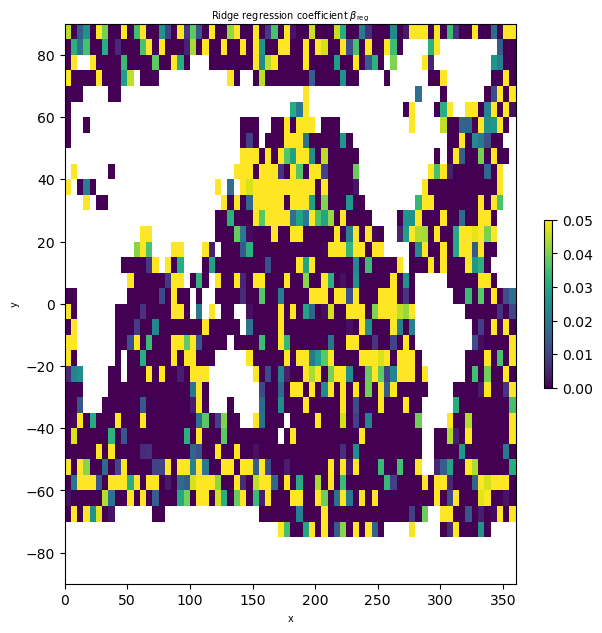

In [27]:
# define beta to plot
x_to_plot = x.detach().clone()
x_to_plot = torch.squeeze(x_to_plot)
x_to_plot[nans_idx] = float('nan')
x_to_plot = x_to_plot.detach().numpy().reshape(lat.shape[0],lon.shape[0])


fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Ridge regression coefficient $\beta_{\mathrm{reg}}$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,x_to_plot,vmin=-0.00,vmax = 0.05)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)